# Redis as a high-performance machine learning database
## NLP : Identifying toxic comments

## Part 1: Data Exploration and cleaning
In this first part we'll explore the `jigsaw-toxic-comment-classification-challenge` and prototype some data cleaning function to prepare the dataset for be inserted into the local Redis DB.

In [132]:
import pandas as pd

Let's first store our training dataset in our Redis database for easy access. For this project, we'll be using the `jigsaw-toxic-comment-classification-challenge` dataset to train our NLP model in classifying toxic comments. 

You **must** first download the training dataset and extract the archive in the `data/` sub-directory of this project.

In [133]:
# Let's first do a small EDA of our training data
train_df = pd.read_csv("data/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [134]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Our dataset contains ~160k entries. The training dataset also comes with a testing dataset in `data/test.csv` as well as the classification results in `data/test_labels.csv`.

<Axes: >

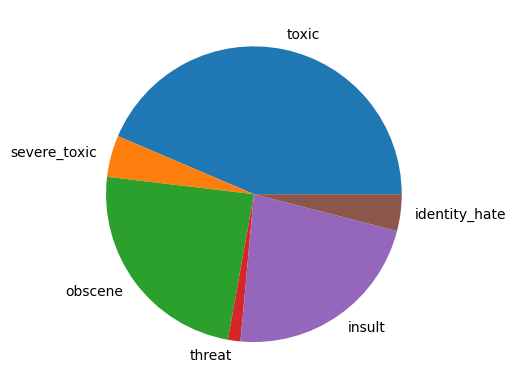

In [135]:
train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='pie')

Above you see the overall distribution of toxic comments and how they are distributed given their label. For this project we'll focus on classifying examples based on 6 of those labels. More specifically, we're interested if a comment fall within any of these categories: `['normal', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate']`. For this, we'll merge the `toxic` and `severe_toxic` comments together (we'll be doing multi-label classification using NLP on those comments). We'll also be introducing a new column called `normal` and only place a 1 iff all the other classes are set to `0`.


In [136]:
import numpy as np
# merge severe_toxic & toxic together
train_df.loc[train_df["severe_toxic"] == 1, ['toxic']] = 1 
train_df = train_df.drop(columns=['severe_toxic'])
# add in normal column
train_df['normal'] = np.where((train_df["toxic"] == 0) & (train_df["obscene"] == 0) & (train_df["threat"] == 0) & (train_df["insult"] == 0) & (train_df["identity_hate"] == 0), 1.0, 0.0)
# column types
train_df['normal'] = train_df['normal'].astype(float)
train_df['toxic'] = train_df['toxic'].astype(float)
train_df['obscene'] = train_df['obscene'].astype(float)
train_df['threat'] = train_df['threat'].astype(float)
train_df['insult'] = train_df['insult'].astype(float)
train_df['identity_hate'] = train_df['identity_hate'].astype(float)

You also see that the `comment_text` column need some cleaning work in order to make it work well with the neural network and tokenizer. To do so, we'll simply clean all non-alpha character and convert everything to lowercase.

In [137]:
import re
def clean_comment_text(comment_text):
    return re.sub(r'[^a-zA-Z ]+', '', comment_text)
train_df['comment_text'] = train_df['comment_text'].apply(clean_comment_text)
train_df = train_df.dropna(how='all')
train_df

,id,comment_text,toxic,obscene,threat,insult,identity_hate,normal
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0.0,0.0,0.0,0.0,0.0,1.0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0.0,0.0,0.0,0.0,0.0,1.0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0.0,0.0,0.0,0.0,0.0,1.0
3,0001b41b1c6bb37e,MoreI cant make any real suggestions on improv...,0.0,0.0,0.0,0.0,0.0,1.0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,And for the second time of asking when your vi...,0.0,0.0,0.0,0.0,0.0,1.0
159567,ffea4adeee384e90,You should be ashamed of yourself That is a ho...,0.0,0.0,0.0,0.0,0.0,1.0
159568,ffee36eab5c267c9,Spitzer Umm theres no actual article for prost...,0.0,0.0,0.0,0.0,0.0,1.0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0.0,0.0,0.0,0.0,0.0,1.0


We'll now process the testing dataset in a similar fashion, in the case of the jigsaw dataset, testing labels come in separately in a `test_label.csv` file and are joined on the `id` field.

In [138]:
# load testing dataset
test_df = pd.read_csv("data/test.csv")
test_df_labels = pd.read_csv("data/test_labels.csv")

# merge both datasets
test_df = pd.merge(test_df, test_df_labels, on='id', how='inner')
test_df = test_df[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


It also seem like the testing dataset contains a lot of `-1` entries. According to the jigsaw dataset, `test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)`. We'll remove those entries and treat the testing dataset the same way we did with the training dataset.

In [139]:
indexes_invalid = test_df[(test_df['toxic'] == -1) | (test_df['severe_toxic'] == -1) | (test_df['obscene'] == -1) | (test_df['threat'] == -1) | (test_df['insult'] == -1)  | (test_df['identity_hate'] == -1)]
indexes_invalid

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [140]:
test_df = test_df.drop(indexes_invalid.index)

# merge severe_toxic & toxic together
test_df.loc[test_df["severe_toxic"] == 1, ['toxic']] = 1 
test_df = test_df.drop(columns=['severe_toxic'])
# add in normal column
test_df['normal'] = np.where((test_df["toxic"] == 0) & (test_df["obscene"] == 0) & (test_df["threat"] == 0) & (test_df["insult"] == 0) & (test_df["identity_hate"] == 0), 1.0, 0.0)
# column types
test_df['normal'] = test_df['normal'].astype(float)
test_df['toxic'] = test_df['normal'].astype(float)
test_df['obscene'] = test_df['obscene'].astype(float)
test_df['threat'] = test_df['threat'].astype(float)
test_df['insult'] = test_df['insult'].astype(float)
test_df['identity_hate'] = test_df['identity_hate'].astype(float)
test_df['comment_text'] = train_df['comment_text'].apply(clean_comment_text)
test_df = test_df.dropna(how='all')
test_df

,id,comment_text,toxic,obscene,threat,insult,identity_hate,normal
5,0001ea8717f6de06,Congratulations from me as well use the tools ...,1.0,0.0,0.0,0.0,0.0,1.0
7,000247e83dcc1211,Your vandalism to the Matt Shirvington article...,1.0,0.0,0.0,0.0,0.0,1.0
11,0002f87b16116a7f,bbq be a man and lets discuss itmaybe over the...,1.0,0.0,0.0,0.0,0.0,1.0
13,0003e1cccfd5a40a,Before you start throwing accusations and warn...,1.0,0.0,0.0,0.0,0.0,1.0
14,00059ace3e3e9a53,Oh and the girl above started her arguments wi...,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,BP First of all I understand that you have a ...,1.0,0.0,0.0,0.0,0.0,1.0
153151,fff9d70fe0722906,Lists is there a list o Kuwaiti women writers...,1.0,0.0,0.0,0.0,0.0,1.0
153154,fffa8a11c4378854,Clarification the article as I an emancipated ...,1.0,0.0,0.0,0.0,0.0,1.0
153155,fffac2a094c8e0e2,For readding a heavily disputed and clearly PO...,0.0,1.0,0.0,1.0,0.0,0.0


We'll then save this data as `data/train_cleaned.csv` and `data/test_cleaned.csv`.

In [141]:
train_df.to_csv("data/train_cleaned.csv")
test_df.to_csv("data/test_cleaned.csv")

Now you can proceed to insert this cleaned data onto your Redis instance. To do so, run `pyhton ./fill_db.py`.